In [14]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [15]:
members = pd.read_csv("/Users/andrewleonard/Library/Mobile Documents/com~apple~CloudDocs/R Practice/CAC/CAC Cancels/AllclubsJune2016/cancelsJune2016.csv")
trainers = pd.read_csv("/Users/andrewleonard/Library/Mobile Documents/com~apple~CloudDocs/R Practice/CAC/CAC Cancels/AllclubsJune2016/cactrainers.csv")


/Users/andrewleonard/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/andrewleonard/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/andrewleonard/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/andrewleonard/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

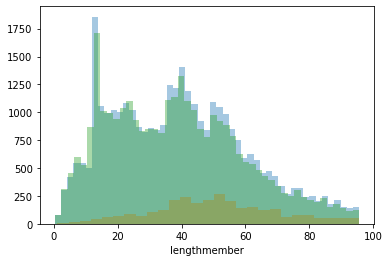

In [16]:
members['Agreement #'] = members['Agreement #'].astype('str')
        
#pull out duplicates
members.drop_duplicates(subset ="Agreement #", keep = 'first', inplace = True)

#members['Today'] = datetime.date(datetime.now())
members['Today'] = "2019-05-01"
members['Today'] = members['Today'].astype('datetime64[ns]')
members['Status Date'] = members['Status Date'].astype('datetime64[ns]')
members['Member Since Date'] = members['Member Since Date'].astype('datetime64[ns]') 

idxA = members['Member Status'] == 'Ok'
active = members[idxA]

active['lengthmember'] = active['Today'] - active['Member Since Date']
active['lengthmember'] = active['lengthmember'].dt.days
active['lengthmember'] = active['lengthmember'].astype('int32')


idxC = members['Member Status'] == 'Cancelled'
cancelled  = members[idxC]

cancelled['lengthmember'] = cancelled['Status Date'] - cancelled['Member Since Date']
cancelled['lengthmember'] = cancelled['lengthmember'].dt.days
cancelled['lengthmember'] = cancelled['lengthmember'].astype('int32')


members = active.append(cancelled)
members = members.reset_index()
    
#add variables
members['checkin.per.month'] =  members['Check In Count']/members['lengthmember']*30
members['nocheckin'] = np.where(members['Check In Count'] <= 5, 1, 0)

#drop 0 length members
members[members['checkin.per.month'].isnull()].index.tolist()

members = members.drop(11262)
members = members.drop(11294)

#add variables back to active for merge
idxA = members['Member Status'] == 'Ok'
active = members[idxA]

june2016canc = members[(members['Member Status'] != 'Ok') & (members['Status Date'] > "2016-05-31")]

june2016 = june2016canc.append(active)

june2016.lengthmember.mean()/30/12

sns.distplot(a=june2016['lengthmember']/30, kde=False)

june2016.lengthmember.quantile([.25,.5,.75])/30

#pull bukcktown only
buck = trainers.loc[trainers['Club Nbr'] == 8791]
buckclients = pd.merge(june2016, buck, on = 'Agreement #')
 
clients = june2016.merge(trainers, on = 'Agreement #')      
clients.drop_duplicates(subset = 'Agreement #', keep = 'first', inplace = True)                         

#code for non-merge alternative, do not get columns from trainer's file 
#get non clients                 
june2016 = june2016.reset_index()                 
idx = june2016['Agreement #'].isin(clients['Agreement #'])
#clients = june2016.loc[idx,]               
nonclients = june2016.loc[-idx,]

sns.distplot(a=clients['lengthmember']/30, kde=False)
sns.distplot(a=nonclients['lengthmember']/30, kde=False)   
clients['lengthmember'].mean()/30
nonclients['lengthmember'].mean()/30                       

#add new variables to june2016
june2016['genderbionary'] = np.where(june2016.Gender == 'Male', 1, 0)
june2016['clientbionary'] = np.where(june2016['Agreement #'].isin(clients['Agreement #']), 1, 0)
june2016.Age = june2016.Age.fillna(june2016.Age.mean())

In [21]:
june2016

level_0  index                  Club Name Agreement # Member Status  \
0        11258     21     Bucktown Athletic Club   879197539     Cancelled   
1        11260     23     Bucktown Athletic Club   879100236     Cancelled   
2        11289     52     Bucktown Athletic Club   879198029     Cancelled   
3        11290     53     Bucktown Athletic Club   879197463     Cancelled   
4        11295     58     Bucktown Athletic Club   879100105     Cancelled   
...        ...    ...                        ...         ...           ...   
33493    11232  76851  Wicker Park Athletic Club   879996693            Ok   
33494    11233  76852  Wicker Park Athletic Club   879994431            Ok   
33495    11234  76853  Wicker Park Athletic Club   879998135            Ok   
33496    11235  76854  Wicker Park Athletic Club   879989643            Ok   
33497    11236  76855  Wicker Park Athletic Club   879991712            Ok   

      Member Name (last, first) Membership Type  Begin Date Member Since Date  \
0                MCDANIEL, LORY       MULTICLUB  03/29/2016        2016-03-29   
1         CACCIATORE, MARY BETH      ALL ACCESS  05/13/2016        2016-05-13   
2             ODONNELL, CHELSIE       MULTICLUB  02/12/2016        2016-02-12   
3                 MARTY, CALVIN      ALL ACCESS  02/29/2016        2016-02-29   
4                SLATER, GEORGE      ALL ACCESS  05/03/2016        2016-05-03   
...                         ...             ...         ...               ...   
33493              PARK, JEANAH       MULTICLUB  11/12/2013        2013-11-12   
33494           KOEBNICK, EMILY       MULTICLUB  03/11/2015        2015-03-11   
33495          SHANLEY, KIRSTIE       MULTICLUB  11/30/2014        2014-11-30   
33496    ALCAZARANSELMO, GLADYS      ALL ACCESS  08/30/2013        2013-08-30   
33497           DIDOMENICO, BOB      ALL ACCESS  04/21/2014        2014-04-21   

            Date Signed  ... Check In Count  Gender   Age Last Visit Date  \
0                   NaN  ...              0  Female  29.0             NaN   
1      05/13/2016 00:00  ...              0  Female  57.0             NaN   
2                   NaN  ...              0    Male  33.0             NaN   
3                   NaN  ...              0    Male  36.0             NaN   
4      05/03/2016 00:00  ...              0    Male  29.0             NaN   
...                 ...  ...            ...     ...   ...             ...   
33493               NaN  ...           2064  Female  43.0      05/05/2019   
33494               NaN  ...           2080  Female  33.0      05/06/2019   
33495               NaN  ...           2624  Female  40.0      05/05/2019   
33496               NaN  ...           2634  Female  54.0      05/03/2019   
33497               NaN  ...           2679    Male  54.0      05/03/2019   

           Today lengthmember checkin.per.month nocheckin genderbionary  \
0     2019-05-01           93          0.000000         1             0   
1     2019-05-01          275          0.000000         1             0   
2     2019-05-01          170          0.000000         1             1   
3     2019-05-01          156          0.000000         1             1   
4     2019-05-01          609          0.000000         1             1   
...          ...          ...               ...       ...           ...   
33493 2019-05-01         1996         31.022044         0             0   
33494 2019-05-01         1512         41.269841         0             0   
33495 2019-05-01         1613         48.803472         0             0   
33496 2019-05-01         2070         38.173913         0             0   
33497 2019-05-01         1836         43.774510         0             1   

      clientbionary  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
33493             0  
33494             0  
33495             0  
33496             0  
33497             0  

[33498

In [175]:
X = june2016[['Age', 'checkin.per.month']]

1993035.3888720179
1531586.9277682854
1275107.2478878347
1055031.929706694
938195.2827577566
822089.0126914073
729155.9573435194
663120.0889878082


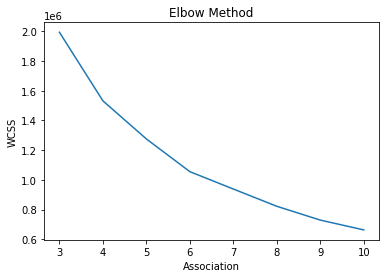

In [124]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
#Within-Cluster-Sum-of-Squares WCSS
wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(X)
    print(kmeans.inertia_)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(3, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [187]:
# Perform the necessary imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=10, n_init = 100)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

#turn X into array
#X = X.values

# Fit pipeline to X
pipeline.fit(X)

# Determine the cluster labels of new_points: labels
labels = pipeline.predict(X)

In [188]:
#use inverse_transform to get cluster centers
scaler.inverse_transform(kmeans.cluster_centers_)

array([[38.04786104,  2.67896143],
       [47.45835387, 10.76212113],
       [67.77172583,  5.58789531],
       [31.41071892,  7.95699214],
       [29.16762442,  2.55357028],
       [50.88590604, 48.34014372],
       [50.7736227 ,  2.70720815],
       [47.60025399, 25.35559632],
       [32.34766194, 15.30279157],
       [ 4.28110599,  4.36584355]])

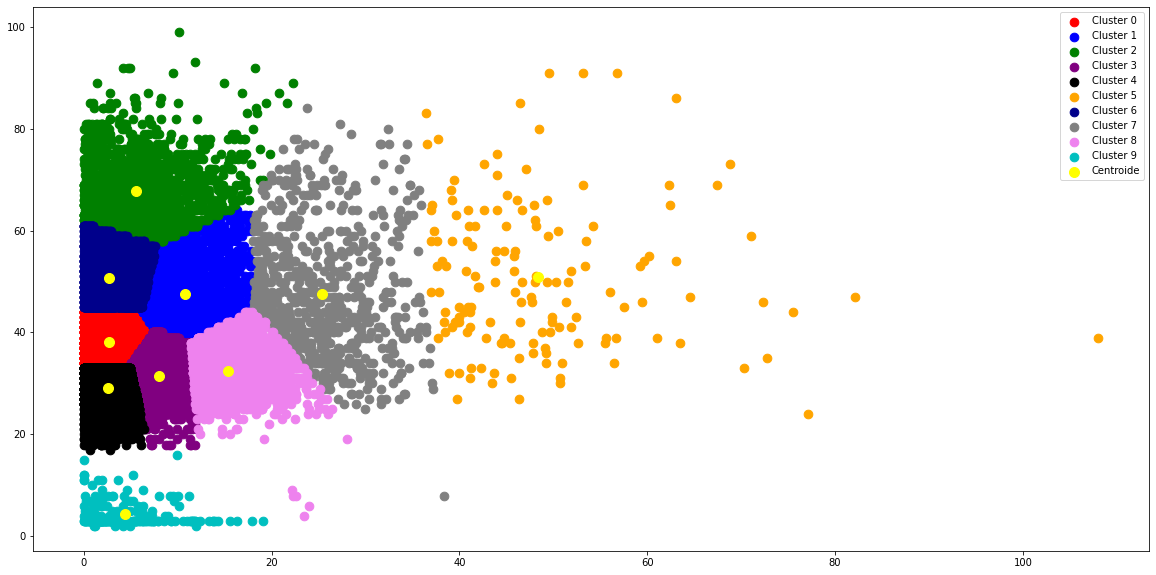

In [189]:
plt.figure(figsize=(20,10))
#Visualising the clusters
plt.scatter(X[labels == 0, 1], X[labels == 0, 0], s = 75, 
            c = 'red', label = 'Cluster 0')
plt.scatter(X[labels == 1, 1], X[labels == 1, 0], s = 75, 
            c = 'blue', label = 'Cluster 1')
plt.scatter(X[labels == 2, 1], X[labels == 2, 0], s = 75, 
            c = 'green', label = 'Cluster 2')
plt.scatter(X[labels == 3, 1], X[labels == 3, 0], s = 75, 
            c = 'purple', label = 'Cluster 3')
plt.scatter(X[labels == 4, 1], X[labels == 4, 0], s = 75, 
            c = 'black', label = 'Cluster 4')
plt.scatter(X[labels == 5, 1], X[labels == 5, 0], s = 75, 
            c = 'orange', label = 'Cluster 5')
plt.scatter(X[labels == 6, 1], X[labels == 6, 0], s = 75, 
            c = 'darkblue', label = 'Cluster 6')
plt.scatter(X[labels == 7, 1], X[labels == 7, 0], s = 75, 
            c = 'grey', label = 'Cluster 7')
plt.scatter(X[labels == 8, 1], X[labels == 8, 0], s = 75, 
            c = 'violet', label = 'Cluster 8')
plt.scatter(X[labels == 9, 1], X[labels == 9, 0], s = 75, 
            c = 'c', label = 'Cluster 9')


#Plotting the centroids of the clusters
plt.scatter(scaler.inverse_transform(kmeans.cluster_centers_)[:,1],
            scaler.inverse_transform(kmeans.cluster_centers_)[:,0], s = 100,
            c = 'yellow', label = 'Centroide')

plt.legend()

In [190]:
cluster_size = np.unique(labels, return_counts=True)

pd.DataFrame(list(cluster_size[1]), columns = ['Cluster_size'])

Cluster_size
0          7504
1          2023
2          1634
3          6482
4          9229
5           149
6          2996
7           735
8          2529
9           217

In [191]:
#Using density based spacial clustering
#not a good fit for this dataset
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 2, min_samples = 15).fit(X)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

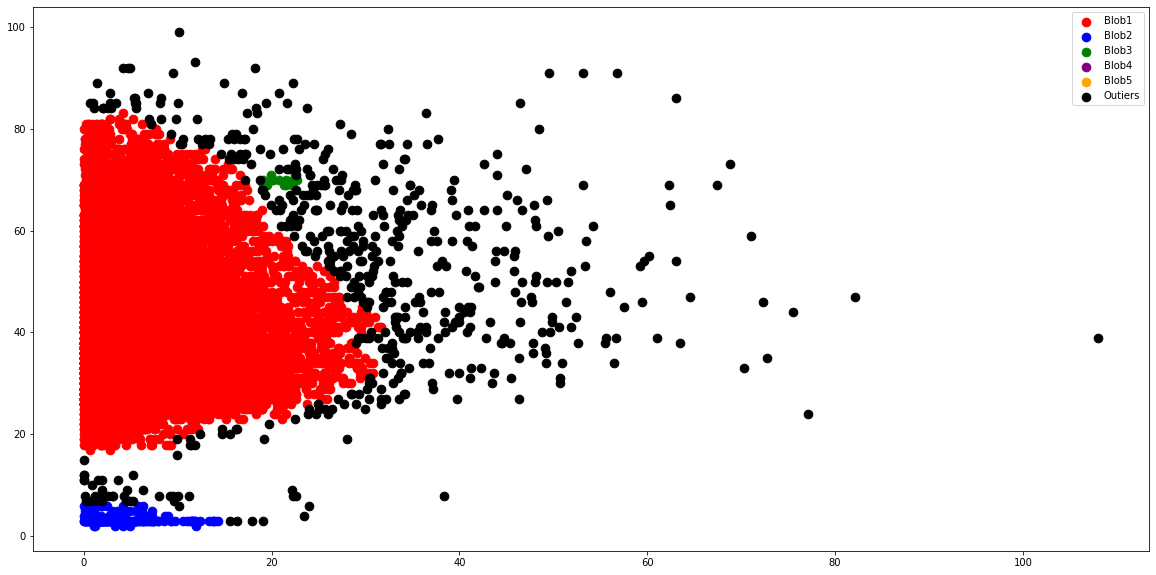

In [192]:
plt.figure(figsize=(20,10))
#Visualising the clusters
plt.scatter(X[labels == 0, 1], X[labels == 0, 0], s = 75, 
            c = 'red', label = 'Blob1')
plt.scatter(X[labels == 1, 1], X[labels == 1, 0], s = 75, 
            c = 'blue', label = 'Blob2')
plt.scatter(X[labels == 2, 1], X[labels == 2, 0], s = 75, 
            c = 'green', label = 'Blob3')
plt.scatter(X[labels == 3, 1], X[labels == 3, 0], s = 75, 
            c = 'purple', label = 'Blob4')
plt.scatter(X[labels == 4, 1], X[labels == 4, 0], s = 75, 
            c = 'orange', label = 'Blob5')
plt.scatter(X[labels == -1, 1], X[labels == -1, 0], s = 75, 
            c = 'black', label = 'Outiers')

plt.legend()